# 2) EDA Notebook
Key Deliverables - By the end of this milestone, should have produced many plots exploring both energy and temperature across different intervals of time as well as a plot relating the two. This last scatter plot just related energy to temperature (not over time) is crucial to building the model in the next phase. You should see something with a pattern like the following Energy and Temp Scatter below.

#### Library Import

In [8]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import dirname

from IPython.core.display import HTML

#### Load Data

In [9]:
# Point toward data directory
data_directory = dirname(os.getcwd()) + '\\data\\interim'

# Read CSV
train_data = pd.read_csv(data_directory + '\\train_data.csv')
display(train_data.head())

date  temp        mw  hour  day  weekday  month  year  doy  \
0  2017-02-01 00:53:00  37.0  1419.881     0    1        2      2  2017   32   
1  2017-02-01 01:53:00  37.0  1379.505     1    1        2      2  2017   32   
2  2017-02-01 02:53:00  36.0  1366.106     2    1        2      2  2017   32   
3  2017-02-01 03:53:00  36.0  1364.453     3    1        2      2  2017   32   
4  2017-02-01 04:53:00  36.0  1391.265     4    1        2      2  2017   32   

   week  
0     5  
1     5  
2     5  
3     5  
4     5

## Relationship Between Temperature and Energy
Let's first look at the relationship between Temeperature and Energy Consumption.

#### Temperature vs Energy
One of the immediate insights we can see from plotting temperature vs energy is how this relationship is impacted at the tail ends of temperature. This idea makes sense, as more energy is needed to warm a home when temperatures are very low, and similarily more energy is needed to cool a home on a hot summer day.  

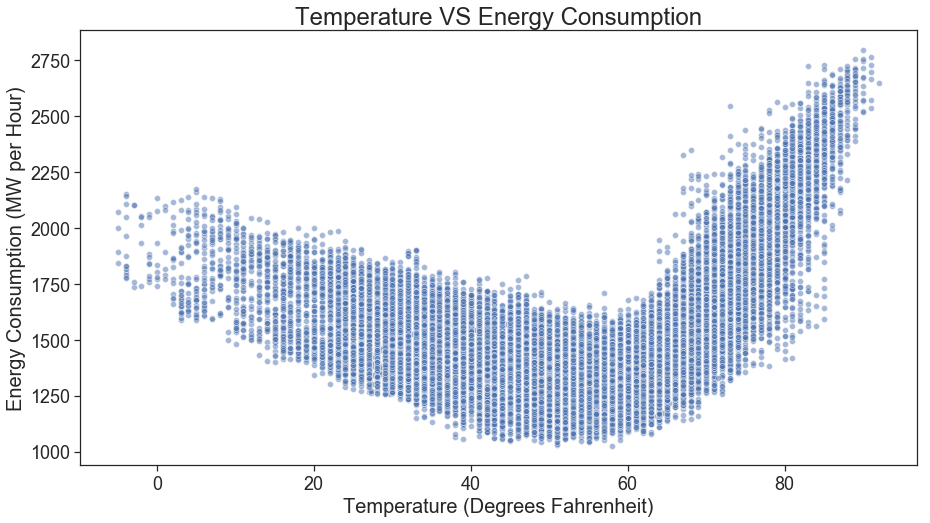

In [10]:
# Setting some stylistic options for matplotlib
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
sns.scatterplot(data = train_data, x = 'temp',y = 'mw',alpha = 0.5)

#Managing Axes Labels
plt.xlabel('Temperature (Degrees Fahrenheit)', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Temperature VS Energy Consumption', fontsize = 24)

plt.show()

#### Correlation Between Temp and Energy Consumption

If we look at a linear correlation between temperature and energy consumption on all of our data we  get somewhat of a misleading statistic. This is because this correlation statistic is best suited for linear data, which evident from our graph above is not the case. 

In [66]:
overall_corr_coef = train_data[['temp','mw']].corr()['temp'][1]
print(f'Overall Correlation : {overall_corr_coef}')

Overall Correlation : 0.3275395569074104


#### Splitting Data Based on Temp
We can get a better idea of this correlation between temp and energy consumption by splitting our data based on temperature. We can see a pretty decisive split in energy consumption at a temperature threshold of 60 degrees. Let's create two data sets based on this break point and then calculate correlation. 

We can see a much stronger relationship between these two variables based on this split in the data. 

In [67]:
high_temp_corr = train_data[train_data.temp >= 60][['temp','mw']].corr()['temp'][1]
low_temp_corr = train_data[train_data.temp < 60][['temp','mw']].corr()['temp'][1]

print(f'High Temperature Correlation Coef: {high_temp_corr} \nLow Temperature Correlation Coef: {low_temp_corr}')

High Temperature Correlation Coef: 0.8512776518700705 
Low Temperature Correlation Coef: -0.6001933477407604


#### Adding Time Components To This View
Let's layer in some idea of how consumption changes when we incorporate what time of day the reading occured at. 

In [16]:
# Create Time of Day Logic
def day_night(x):
    
    if  0 <= x <= 6:
        return 'Early Morning'
    elif 6 < x <=12:
        return 'Late Morning'
    elif 12 < x <= 18:
        return 'Afteroon'
    elif 18 < x <=24:
        return 'Evening'
    
def season( x ):
    if x in range(80, 172):
        return 'Spring'
    elif x in range(172, 264):
        return 'Summer'
    elif x in range(264, 355):
        return 'Fall'
    else:
        return 'Winter'
# Applying logic defined in above function to our hour column
train_data['season'] = train_data.doy.apply(season)
train_data['time_of_day'] = train_data.hour.apply(day_night)
train_data.head(10)

date  temp        mw  hour  day  weekday  month  year  doy  \
0  2017-02-01 00:53:00  37.0  1419.881     0    1        2      2  2017   32   
1  2017-02-01 01:53:00  37.0  1379.505     1    1        2      2  2017   32   
2  2017-02-01 02:53:00  36.0  1366.106     2    1        2      2  2017   32   
3  2017-02-01 03:53:00  36.0  1364.453     3    1        2      2  2017   32   
4  2017-02-01 04:53:00  36.0  1391.265     4    1        2      2  2017   32   
5  2017-02-01 05:53:00  36.0  1477.343     5    1        2      2  2017   32   
6  2017-02-01 06:53:00  34.0  1585.252     6    1        2      2  2017   32   
7  2017-02-01 07:53:00  33.0  1671.412     7    1        2      2  2017   32   
8  2017-02-01 08:53:00  34.0  1708.597     8    1        2      2  2017   32   
9  2017-02-01 09:53:00  35.0  1713.813     9    1        2      2  2017   32   

   week  season    time_of_day  
0     5  Winter  Early Morning  
1     5  Winter  Early Morning  
2     5  Winter  Early Morning  
3     5  Winter  Early Morning  
4     5  Winter  Early Morning  
5     5  Winter  Early Morning  
6     5  Winter  Early Morning  
7     5  Winter   Late Morning  
8     5  Winter   Late Morning  
9     5  Winter   Late Morning

#### High Consumption Events Occur During Hot Afternoon Days
We can see that our highest energy consumption days are typically hot afternoon days. We also see low consumption in early morning hours as people are typically asleep. 

In [19]:
import plotly.express as px

fig = px.scatter(train_data
                 ,color_discrete_sequence = ['#1E88E5', '#004D40', '#EE6677', '#FFC107']
                 ,x = 'temp'
                 ,range_x = [-10,100]
                 ,y = 'mw'
                 ,range_y = [900,3000]
                 ,color = 'time_of_day'
                 , labels = {
                     'temp': 'Temperature (Degrees Fahrenheit)'
                     ,'mw': "Energy Consumption (MW per Hour)"
                     ,'time_of_day': "Time of Day"
                     
                 }
                 ,title = 'Temperature vs Energy Consumption (Time of Day Effects)'
                )
fig.show()

## Double click on a season to view them seperately from eachother

#### Seasonality Affects Consumption
We see higher our higher consumption/higher temp days in summer and higher consumption/ lower temp days in winter.

In [15]:
fig = px.scatter(train_data
                 ,color_discrete_sequence = px.colors.qualitative.Safe
                 ,x = 'temp'
                 ,range_x = [-10,100]
                 ,y = 'mw'
                 ,range_y = [900,3000]
                 ,color = 'season'
                 , labels = {
                     'temp': 'Temperature (Degrees Fahrenheit)'
                     ,'mw': "Energy Consumption (MW per Hour)"
                     ,'season': "Season"
                     
                 }
                 ,title = 'Temperature vs Energy Consumption (Seasonal Effects)'
                )
fig.show()

## Plotting Energy over Time
Let's begin looking at how energy consumption changes over time. We will start with just plotting all of our hourly data across time.

#### All Energy Data
We can begin to see some patterns involved around the seasons, however this view is a little noisy.

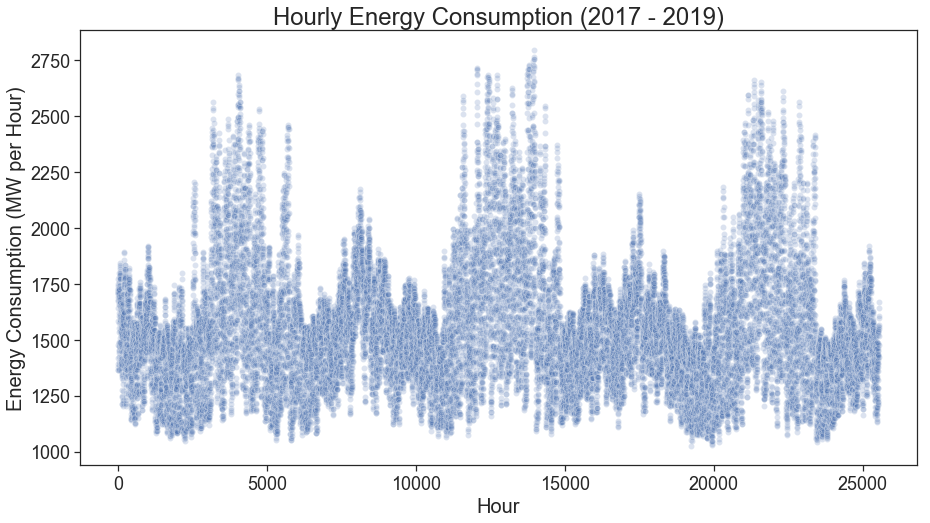

In [22]:
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
sns.scatterplot(x = train_data.index, y = train_data.mw, alpha = 0.2)

#Managing Axes Labels
plt.xlabel('Hour', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Hourly Energy Consumption (2017 - 2019)', fontsize = 24)

plt.show()

#### Average Daily Energy Consumption
By looking at daily average energy consumption we can see how drastic seasonal effects have on our energy consumption. The more moderate seasons (Fall/Spring) show valleys in terms of energy consumption when compared to more extreme seasons (Summer/Winter). The highest energy consumption time of the year is the summer period, which we have already seen demonstrated in the graph comparing temp vs energy consumption. 

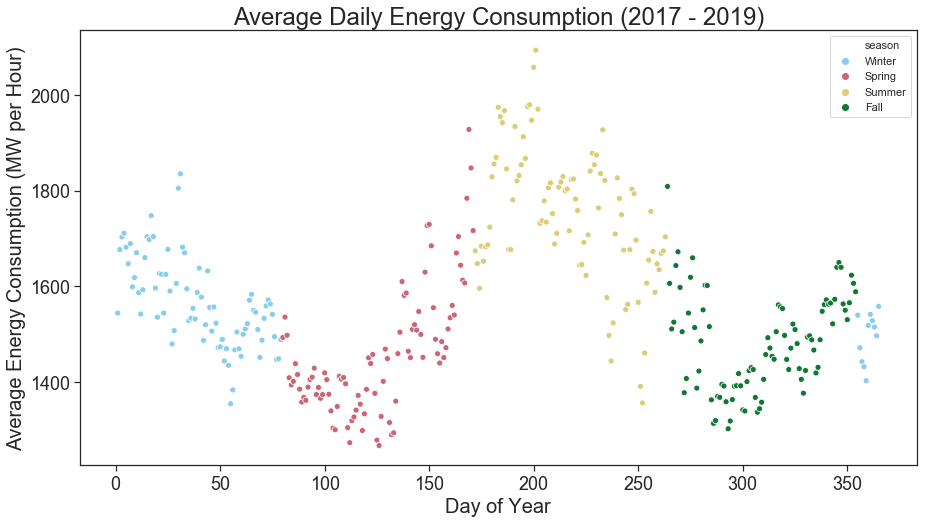

In [24]:
avg_daily = train_data.groupby(['doy']).mean()[['mw']].reset_index()
avg_daily['season'] = avg_daily.doy.apply(season)

fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
sns.scatterplot(data = avg_daily, x = 'doy',y = 'mw', hue  = 'season', palette = ['#88ccee', '#cc6677','#ddcc77','#117733'])

#Managing Axes Labels
plt.xlabel('Day of Year', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Average Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Average Daily Energy Consumption (2017 - 2019)', fontsize = 24)

plt.show()

#### Hourly Energy Consumption
Let's Plot a specific week of data. We will look at week 26 (summer) of 2019. From the plot below we can see the cylcical changes in energy consumption throughout the week. This is coming from higher energy consumption in the day, and lower energy consumption in the evenings.

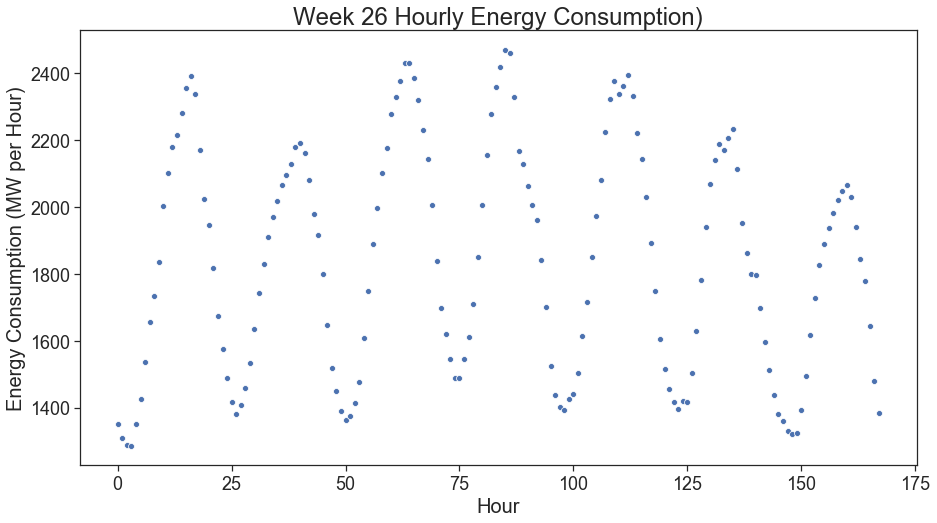

In [25]:
week_data = train_data[(train_data.week == 26) & (train_data.year == 2019)].reset_index()
week_data.hour = week_data.index

#Plotting
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
sns.scatterplot(data = week_data, x = 'hour',y = 'mw')

#Managing Axes Labels
plt.xlabel('Hour', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Week 26 Hourly Energy Consumption)', fontsize = 24)

plt.show()

#### Hourly Energy Consumption Stratified by Week
We can get a better idea of how energy consumption looks by also stratifying by weekday. From the plot below we can see how energy consumption varies from day to day. We can see that Sunday for exmaple has lower energy consumption relative to the other weekdays

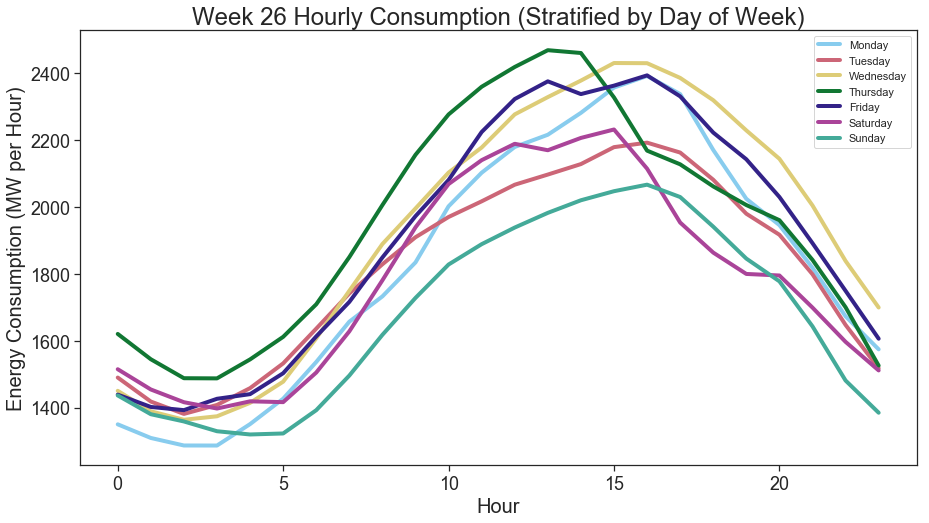

In [28]:
hourly_data = train_data[(train_data.week == 26) & (train_data.year == 2019)]

fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
c = ['#88ccee', '#cc6677','#ddcc77','#117733', '#332288','#aa4499','#44aa99']
sns.lineplot(data = hourly_data, x = 'hour',y = 'mw', hue  = 'weekday', palette = c)

#Managing Axes Labels
plt.xlabel('Hour', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Week 26 Hourly Consumption (Stratified by Day of Week)', fontsize = 24)
plt.legend(labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.show()

#### Average Hourly Data Stratified by Weekday
Based on just one week of data we can see that Sunday has lower energy consumption. We can try validating this claim by aggregating this view for all weeks in our dataset. Looking at the same view as above but from and average of all weeks, we can that both Sunday and Saturday have lower energy consumption.

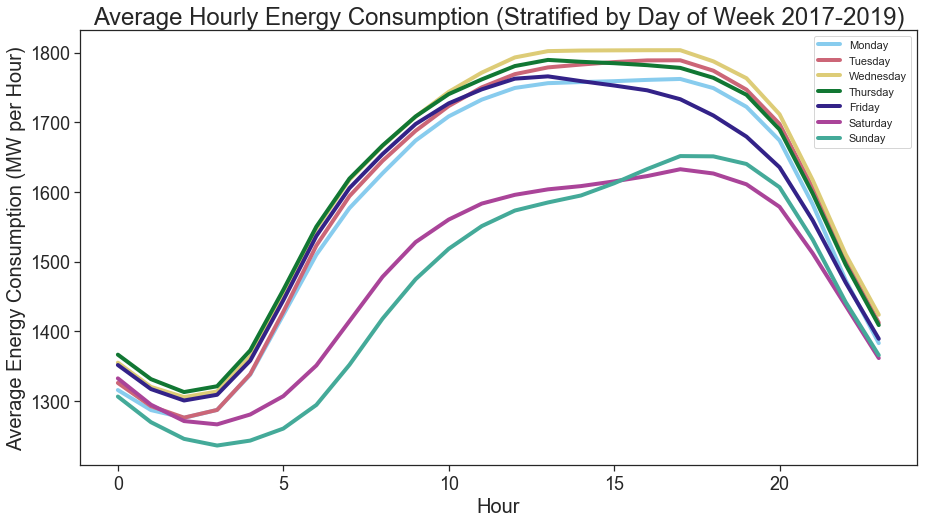

In [29]:
average_hourly_data = train_data.groupby(['weekday','hour'])[['mw']].mean().reset_index()


fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
c = ['#88ccee', '#cc6677','#ddcc77','#117733', '#332288','#aa4499','#44aa99']
sns.lineplot(data = average_hourly_data, x = 'hour',y = 'mw', hue  = 'weekday', palette = c)

#Managing Axes Labels
plt.xlabel('Hour', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Average Energy Consumption (MW per Hour)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Average Hourly Energy Consumption (Stratified by Day of Week 2017-2019)', fontsize = 24)
plt.legend(labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.show()

## Plotting Temperature over Time

Let's begin looking at how temperature  changes over time. We expect to see a close relationship between temperature and energy so we will also get some views of how these change together over time. 

#### All Temperature Data
From plotting all of our temperature data we can decisively see temperature patters that follow the seasons. 

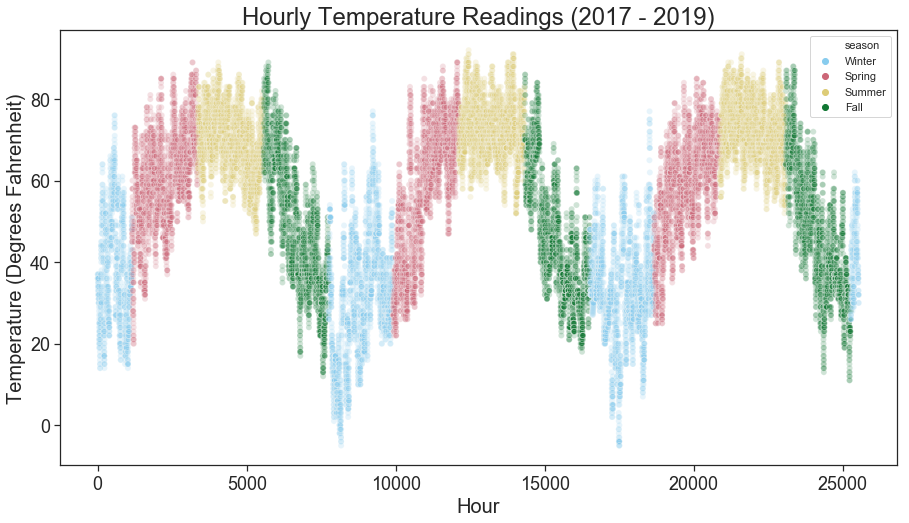

In [60]:
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

# Create Plot Object
sns.scatterplot(x = train_data.index, y = train_data.temp, alpha = 0.2, hue = train_data.season, palette = ['#88ccee', '#cc6677','#ddcc77','#117733'])

#Managing Axes Labels
plt.xlabel('Hour', fontsize = 20)
plt.xticks(fontsize = 18)
plt.ylabel('Temperature (Degrees Fahrenheit)', fontsize = 20)
plt.yticks(fontsize = 18)

plt.title('Hourly Temperature Readings (2017 - 2019)', fontsize = 24)

plt.show()

#### Energy and Temp View over Time
We can see from the graph below how we see both energy and tempature follow eachother. This correlation appears to be positive when temperature is on the higher end (higher temp = higher energy consumption), and negative on the lower end of temperature.

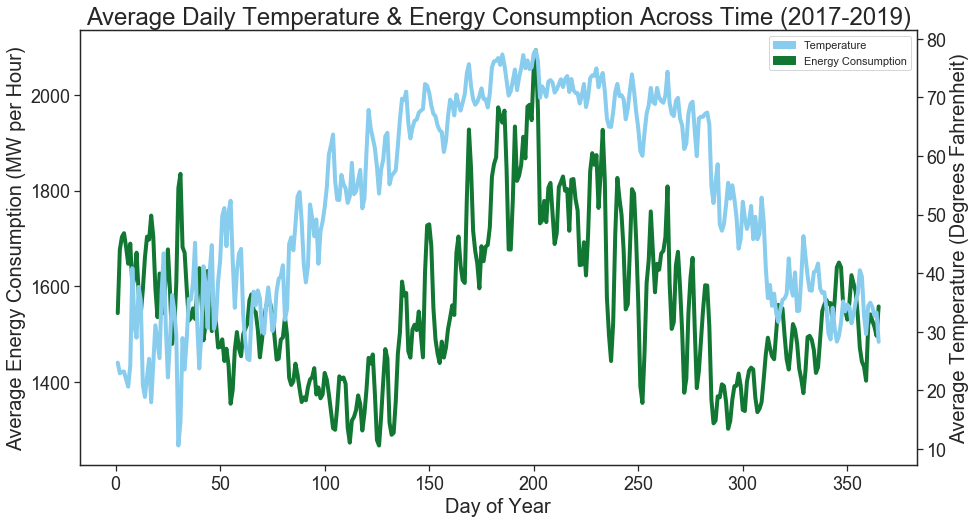

In [57]:
#Aggregating data
average_daily_data_seasons = train_data.groupby(['doy'])[['mw','temp']].mean().reset_index()

import matplotlib.patches as mpatches

#Creating plot object
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

#Creating first plot
ax = sns.lineplot(data = average_daily_data_seasons,x="doy", y="mw", color = '#117733')

#Managing Axes For first plot
plt.xlabel('Day of Year', fontsize = 20)
plt.ylabel('Average Energy Consumption (MW per Hour)', fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

#Creating Second Plot
ax2 = ax.twinx()
sns.lineplot(data = average_daily_data_seasons,x="doy", y="temp", color ='#88ccee')

#Managing labels for second plot
plt.ylabel('Average Temperature (Degrees Fahrenheit)', fontsize = 20)
plt.yticks(fontsize = 18)
plt.title('Average Daily Temperature & Energy Consumption Across Time (2017-2019)', fontsize = 24)

#Managing legend

temp = mpatches.Patch(color='#88ccee', label='Temperature')
energy = mpatches.Patch(color='#117733', label='Energy Consumption')
plt.legend(handles = [temp, energy])

plt.show()

#### Plotting a Week of Energy and Temp Data
We can view a more granular plot of this relationship by looking at a specific week. We will look at Week 2 in 2019 (Winter) and again examine the relationship between energy and temp over time on a hourly basis. This particular week shows us a good view of the falling and rising energy consumption and temperature that mimics day/night cycles. Additionally, this week in particular allows us to see how very cold days (later in the week) lead to higher energy consumption. 

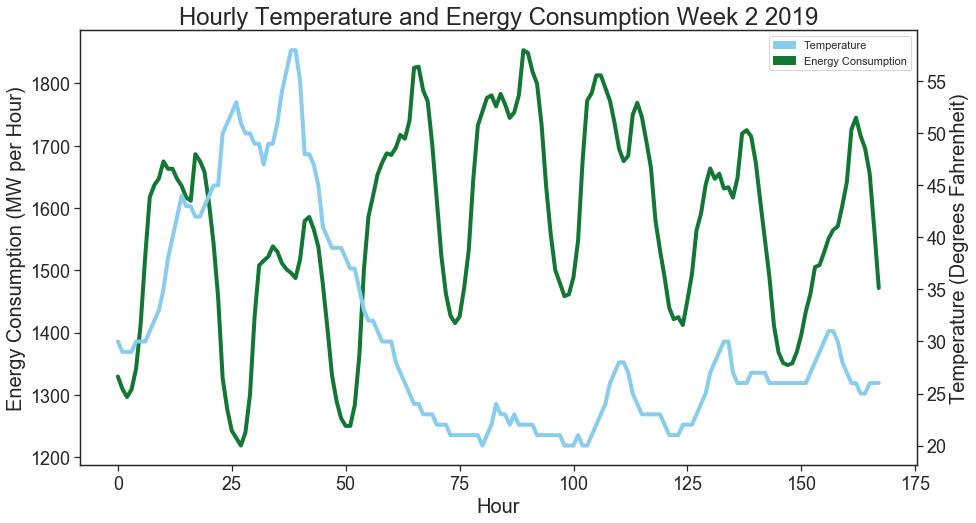

In [61]:
#Aggregating data
winter_week = train_data[(train_data.week == 2) & (train_data.year == 2019)].reset_index()
winter_week.hour = winter_week.index

import matplotlib.patches as mpatches

#Creating plot object
fix, ax = plt.subplots( figsize = (15,8))
sns.set(style = 'ticks', rc = {'lines.linewidth':4})

#Creating first plot
ax = sns.lineplot(data = winter_week,x="hour", y="mw", color = '#117733')

#Managing Axes For first plot
plt.xlabel('Hour', fontsize = 20)
plt.ylabel('Energy Consumption (MW per Hour)', fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

#Creating Second Plot
ax2 = ax.twinx()
sns.lineplot(data = winter_week,x="hour", y="temp", color ='#88ccee')

#Managing labels for second plot
plt.ylabel('Temperature (Degrees Fahrenheit)', fontsize = 20)
plt.yticks(fontsize = 18)
plt.title('Hourly Temperature and Energy Consumption Week 2 2019', fontsize = 24)

#Managing legend

temp = mpatches.Patch(color='#88ccee', label='Temperature')
energy = mpatches.Patch(color='#117733', label='Energy Consumption')
plt.legend(handles = [temp, energy])

plt.show()